# [draft] Predicting Dogecoin uptrends from a Musk's tweet

In [1]:
# tensorflow
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer

# natural language processing
from nltk import word_tokenize

# scikit-learn modelling and preproceesing
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# custom modules
from import_data import *
from text_cleaning import *
from tweets_impact import *

In [2]:
elon_df = import_elon_tweets('../data/elon_tweets.csv')

doge_df = import_crypto_prices('../data/DOGE-USD.csv')
solana_df = import_crypto_prices('../data/SOL-USD.csv')
bitcoin_df = import_crypto_prices('../data/BTC-USD.csv')

In [3]:
days = 3

doge_diffs = tweets_impact(elon_df, doge_df, days).sort_index()
non_doge_diffs = tweets_impact(elon_df, doge_df, days, non_doge=True).sort_index()

df = pd.concat([doge_diffs])

In [4]:
df['parsed_tweet'] = cleaning_pipeline(df.tweet).tidier_tweets
df['sentiment'] = [compute_si(t) for t in df.parsed_tweet]
df['tokenized'] = [word_tokenize(str(t)) for t in df.parsed_tweet.tolist()]

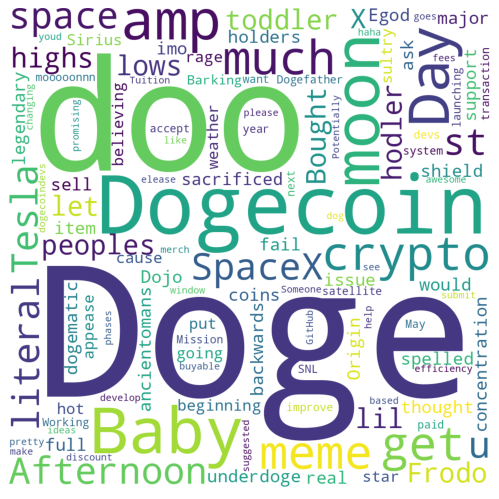

In [5]:
wordcloud(df.parsed_tweet)

## Preprocess and clean data

In [6]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df.tokenized)

X = pd.DataFrame(tokenizer.texts_to_matrix(df.tokenized, mode='freq'))
Y = df.differ_sc.rename('y').reset_index(drop=True)

features_df = pd.concat([X,Y], axis=1)

In [7]:
scaler = MinMaxScaler()

features_df.y = scaler.fit_transform(np.expand_dims(features_df.y.values, axis=1))

features_df = shuffle(features_df)

train_size = int(len(features_df)*0.8)

df_train = features_df[train_size:]
df_test = features_df[:train_size]

X_train = df_train.iloc[:, :-1]
X_test = df_test.iloc[:, :-1]

Y_train = pd.DataFrame(df_train.iloc[:, -1])
Y_test = pd.DataFrame(df_test.iloc[:, -1])

## Predictive models

### Ridge Regression

In [8]:
model = Ridge()

model.fit(X_train, Y_train)

r2 = model.score(X_test, Y_test)
mse = np.mean((model.predict(X_test) - Y_test)**2, axis=0)[0]

print(f'R-squared:\t{r2}\nMSE:\t\t{mse}')

R-squared:	-0.007635084246974566
MSE:		0.02852942155569666


### Simple Neural Network

2022-07-05 11:12:47.273939: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


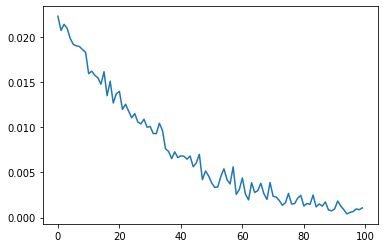

MSE: 0.032456075255169324


In [9]:
model = Sequential()
model.add(Dense(50, activation='relu'))#, kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, Y_train, epochs=100, verbose=0)

plt.plot(hist.history['loss'])
plt.show()

acc = np.mean((model.predict(X_test, verbose=0) - Y_test)**2, axis=0)[0]

print(f'MSE: {acc}')